In [1]:
# Import Sequences

from Bio.Seq import Seq
from Bio import SeqIO

sc1g = SeqIO.read('data/sars_cov_1_genome.fasta', 'fasta')
sc2g = SeqIO.read('data/sars_cov_2_genome.fasta', 'fasta')

print('Length of Sars-Cov-1 Genome: {}'.format(len(sc1g)))
print('Length of Sars-Cov-2 Genome: {}'.format(len(sc1g)))

Length of Sars-Cov-1 Genome: 29751
Length of Sars-Cov-2 Genome: 29751


In [2]:
# Some Library code for Analysis

import os
import matplotlib.pyplot as plt
import numpy as np
from Bio import pairwise2
from Bio import SeqIO
from Bio.Align import substitution_matrices

def seqsim(alignfile):
    blosum62 = substitution_matrices.load("BLOSUM62")

    # basedir = '/Users/davidwang/projects/sarscov2/data'
    # seq1 = SeqIO.read('{}/sars_cov_2_e_prot.fasta'.format(basedir), 'fasta')
    # seq2 = SeqIO.read('{}/mers_cov_e_prot.fasta'.format(basedir), 'fasta')
    # aligns = pairwise2.align.globalds(seq1.seq, seq2.seq, blosum62, -10, -0.5)

    # Read in Sequences Aligned by MAFFT
    aligndata = open(alignfile).read()
    seqs = aligndata.split('>')
    seq1 = ''.join(seqs[1].split('\n')[1:])
    seq2 = ''.join(seqs[2].split('\n')[1:])
    
    return {
        'seq1': seq1,
        'seq2': seq2,
        'similarity': similarity_score(seq1, seq2),
    }

def cdna_to_rna(dna):
    return str(dna).replace('T', 'U')

def similarity_score(ref, seq):
    similar = 0
    
    for i in range(len(ref)):
        if ref[i] == seq[i]:
            similar += 1

    return similar / len(ref)

def plot_protein_sim(data):
    width = 0.25
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    proteins = ['E Protein', 'M Protein', 'N Protein', 'S Protein']
    locs = np.arange(len(data[0]))
    
    ax.set_ylabel('% Sequence  Similarity')
    ax.set_title('Sequence Similarity to Sars-Cov-2')
    
    plt.bar(locs, data[0], color='g', width=width, label=proteins[0])
    plt.bar(locs+width, data[1], color='b', width=width, label=proteins[0])
    plt.xticks(range(len(proteins)), proteins)
    plt.yticks(np.arange(0, 101, 10))
    ax.legend(labels=['Mers-Cov 2012', 'Sars-Cov 2004'])
    
    plt.show()

In [3]:
# Calculate Protein Sequence Similarity Between Sars-Cov, Sars-Cov2, and Mers-Cov

proteins = ['e', 'm', 'n', 's']
sim_results = [[], []]

basedir = '/Users/davidwang/projects/sarscov2/data'
for p in proteins:
    alignfile = '{}/sars_cov_2_mers_cov_{}_prot.ali'.format(basedir, p)
    result = seqsim(alignfile)
    sim_results[0].append(result['similarity']*100)

    basename = os.path.basename(alignfile)
    print('{} Protein Length: {} Similarity: {:.1f}%'.format(basename, len(result['seq1']), result['similarity']*100))
    
for p in proteins:
    alignfile = '{}/sars_cov_2_sars_cov_1_{}_prot.ali'.format(basedir, p)
    result = seqsim(alignfile)
    sim_results[1].append(result['similarity']*100)
    
    basename = os.path.basename(alignfile)
    print('{} Protein Length: {} Similarity: {:.1f}%'.format(basename, len(result['seq1']), result['similarity']*100))

sars_cov_2_mers_cov_e_prot.ali Protein Length: 82 Similarity: 35.4%
sars_cov_2_mers_cov_m_prot.ali Protein Length: 223 Similarity: 40.4%
sars_cov_2_mers_cov_n_prot.ali Protein Length: 450 Similarity: 45.8%
sars_cov_2_mers_cov_s_prot.ali Protein Length: 1451 Similarity: 30.5%
sars_cov_2_sars_cov_1_e_prot.ali Protein Length: 76 Similarity: 94.7%
sars_cov_2_sars_cov_1_m_prot.ali Protein Length: 222 Similarity: 90.5%
sars_cov_2_sars_cov_1_n_prot.ali Protein Length: 422 Similarity: 90.5%
sars_cov_2_sars_cov_1_s_prot.ali Protein Length: 1277 Similarity: 76.0%


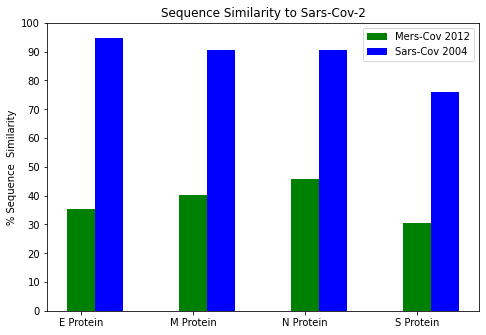

In [4]:
# Plot Protein Sequence Similarity Between Sars-Cov, Sars-Cov2, and Mers-Cov
plot_protein_sim(sim_results)

In [56]:
import pandas as pd

df = pd.read_csv('data/200938383919-sars_cov_vipr_epitopes.tsv', sep='\t')

# ViPR Epitope Analysis

# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7150947/

# Total Number of Epitopes 1394
# Positive T cell assays                                         | T cell epitopes              | 115
# Positive major histocompatibility complex (MHC) binding assays | T cell epitopes              | 959
# Positive B cell assays                                         | Linear B cell epitopes       | 298
#                                                                | Discontinuous B cell epitopes| 6
# ----------------------------------------------------------------------------------------------------
#                                                                | Total                        |1378

# Selection Criteria
# 1. human hosts.
# 2. Only experimentally-determined epitopes associated with at least one positive assay.
# 3. Positive B cell assays (e.g., enzyme-linked immunosorbent assay (ELISA)-based qualitative binding) for B cell epitopes.
# 4. Positive T cell assays 
#      - enzyme-linked immune absorbent spot (ELISPOT)
#      - Intracellular cytokine staining (ICS) IFN-γ release)
#      - Positive major histocompatibility complex (MHC) binding assays for T cell epitopes.

assay_dict = {
    'B Cell': [],
    'T Cell': [],
    'MHC Binding' : [],
}

set_dict = {
    'B Cell': set(),
    'T Cell': set(),
    'MHC Binding' : set(),
}

epitopes = []
for row in df.itertuples():
    human_indicies = [i for i, x in enumerate(row[4].split(',')) if x == 'Human'] # Hosts
    assay_types = row[5].split(',') # Assay Types
    results = row[6].split(',') # Assay Results ['Positive', 'Negative', etc]
    methods = row[9].split(',') # Methods
    positive_indicies = [i for i in human_indicies if 'Positive' in results[i]]
    at_least_one_positive = len(positive_indicies) > 0
    
    for i in human_indicies:
        if not at_least_one_positive:
            continue
            
        if assay_types[i] == 'B Cell' and methods[i] == 'ELISA':
            assay_dict[assay_types[i]].append({
                'index': row[0],
                'id': row[1],
                'method': methods[i],
                'seq': row[2],
                'proteins': row[3],
            })
            break
  
        if assay_types[i] in ['T Cell', 'MHC Binding'] and methods[i] in [
             'ELISPOT',
             'ICS',
             'cellular MHC/competitive/fluorescence',
             'cellular MHC/direct/fluorescence',
             'purified MHC',
             'purified MHC/competitive/fluorescence',
             'purified MHC/competitive/radioactivity',
             'purified MHC/direct/fluorescence',
             'purified MHC/direct/radioactivity',
        ]:
            
            assay_dict[assay_types[i]].append({
                'index': row[0],
                'id': row[1],
                'method': methods[i],
                'seq': row[2],
                'proteins': row[3],
            })
            break
            
# assay_dict
# Get length of epitopes for B-Cell, T-Cell, and MHC
print({k:len(v) for (k, v) in assay_dict.items()})

ids = []
for epitopes in assay_dict.values():
    ids.extend(map(lambda x: x['id'], epitopes))

{'B Cell': 268, 'T Cell': 27, 'MHC Binding': 959}


In [5]:
import pickle
with open('paper_code/2019-nCoV-T-Cell-Vaccine-Candidates/Utils/population_coverage/deps/population-coverage-pickle/population_coverage_pickle/population_genotype_map.p', 'rb') as pf:
    pop_cov = pickle.load(pf)
    country_eth = pickle.load(pickle_file)

In [48]:
allele_freqs = {}

for mhc in ['I', 'II']:
    allele_freqs[mhc] = []
    for allele_f in pop_cov[mhc]['World'].values():
        for a_f in allele_f:
            if a_f[1] > 0.1:
                allele_freqs[mhc].append(a_f)
            


for mhc in ['I', 'II']:
    allele_freq_sort = sorted(allele_freqs[mhc], key=lambda x: x[1], reverse=True)
    print('MHC {}'.format(mhc))
    for a_f in allele_freq_sort:
        print(a_f)

MHC I
('HLA-G*01:01', 0.6893)
('HLA-E*01:01', 0.5032)
('HLA-E*01:03', 0.473)
('HLA-A*02:01', 0.2439)
('HLA-G*01:04', 0.214)
('HLA-C*07:02', 0.1285)
('HLA-A*24:02', 0.1259)
('HLA-C*04:01', 0.1193)
('HLA-C*07:01', 0.1157)
('HLA-G*01:03', 0.1151)
('HLA-A*01:01', 0.1009)
MHC II
('HLA-DMA*01:01', 0.8418)
('HLA-DMB*01:01', 0.7875)
('HLA-DPA1*01:03', 0.45)
('HLA-DPB1*04:01', 0.2399)
('HLA-DQA1*05:01', 0.2282)
('HLA-DQB1*03:01', 0.202)
('HLA-DPB1*101:01', 0.177)
('HLA-DQA1*03:01', 0.1699)
('HLA-DPA1*02:02', 0.1614)
('HLA-DPA1*02:01', 0.1602)
('HLA-DQA1*01:02', 0.1543)
('HLA-DPB1*02:01', 0.154)
('HLA-DMB*01:03', 0.1533)
('HLA-DPB1*05:01', 0.1489)
('HLA-DPB1*04:02', 0.1418)
('HLA-DQB1*02:01', 0.1346)
('HLA-DQA1*01:01', 0.1165)
('HLA-DMA*01:02', 0.1094)
('HLA-DRB1*15:01', 0.1082)
('HLA-DQB1*03:02', 0.1079)
('HLA-DRB1*07:01', 0.1071)
('HLA-DRB1*03:01', 0.1047)
('HLA-DQA1*02:01', 0.1028)


In [51]:
pop_cov['I']['World']

OrderedDict([('HLA-A',
              [('HLA-A*01:01', 0.1009),
               ('HLA-A*01:02', 0.002),
               ('HLA-A*01:03', 0.0005),
               ('HLA-A*01:04', 0.0),
               ('HLA-A*01:06', 0.0002),
               ('HLA-A*01:07', 0.0),
               ('HLA-A*01:08', 0.0),
               ('HLA-A*01:09', 0.0004),
               ('HLA-A*01:10', 0.0),
               ('HLA-A*01:11', 0.0),
               ('HLA-A*01:12', 0.0),
               ('HLA-A*01:13', 0.0),
               ('HLA-A*01:14', 0.0),
               ('HLA-A*01:15', 0.0),
               ('HLA-A*01:16', 0.0),
               ('HLA-A*01:17', 0.0),
               ('HLA-A*01:18', 0.0),
               ('HLA-A*01:19', 0.0),
               ('HLA-A*01:20', 0.0),
               ('HLA-A*01:21', 0.0),
               ('HLA-A*01:22', 0.0),
               ('HLA-A*01:23', 0.0019),
               ('HLA-A*01:24', 0.0),
               ('HLA-A*01:25', 0.0),
               ('HLA-A*01:26', 0.0),
               ('HLA-A*01:27', 0.0)

In [376]:
list(map(lambda x: row[4].split(',')[x[0]], filter(lambda x: x[1] == 'Positive', enumerate(results))))

['Mouse', 'Mouse', 'Mouse', 'Mouse', 'Mouse', 'Mouse', 'Mouse', 'Mouse']

In [381]:
list(map(lambda x: row[5].split(',')[x[0]], filter(lambda x: x[1] == 'Positive', enumerate(results))))

['T Cell',
 'T Cell',
 'T Cell',
 'T Cell',
 'T Cell',
 'T Cell',
 'T Cell',
 'T Cell']

In [57]:
b_df = pd.read_excel('paper_code/2019-nCoV-T-Cell-Vaccine-Candidates/Data/BCell-nCov-Results.xls')
t_df = pd.read_excel('paper_code/2019-nCoV-T-Cell-Vaccine-Candidates/Data/TCell-nCov-Results.xls')
mhc_df = pd.read_excel('paper_code/2019-nCoV-T-Cell-Vaccine-Candidates/Data/MHC-nCov-Results.xls')

all_df = b_df.append(t_df).append(mhc_df)

unique = set()
dup = []

for i in all_df['IEDB ID']:
    if i in unique:
        dup.append(i)
    unique.add(i)

non_human = {
    'B Cell': [],
    'T Cell': [],
    'MHC Binding' : [],
}

epitopes = []
no_human = 0

for row in all_df.itertuples():
    proteins = row[3].split(',')
    hosts = row[4].split(',')
    human_indicies = [i for i, x in enumerate(hosts) if x == 'Human'] # Hosts
    assay_types = row[5].split(',') # Assay Types
    results = row[6].split(',') # Assay Results ['Positive', 'Negative', etc]
    methods = row[9].split(',') # Methods
    human_positive = [i for i in human_indicies if 'Positive' in results[i]]
    positives = [i for i, host in enumerate(hosts) if 'Positive' in results[i]]
    has_human_positive = len(human_positive) > 0

    if positives and not has_human_positive:
        for i, assay in enumerate(assay_types):
            if 'Positive' in results[i]:
                
                non_human[assay].append({
                    'iedb': row[1],
                    'epitope': row[2],
                    'assay': assay,
                    'host': hosts[i],
                })

In [487]:
all_df.head(1)

,IEDB ID,Epitope Sequence,Protein Names,Host,Assay Type Category,Assay Result,MHC Allele Name,MHC Allele Class,Method,Measurement
0,307,AALVSGTATAGWTFGAG,"E2 glycoprotein precursor,spike glycoprotein,","Human,Mouse,Rabbit,Human,Mouse,Rabbit","B Cell,B Cell,B Cell,B Cell,B Cell,B Cell","Positive,Positive,Positive,Positive,Positive,P...","-N/A-,-N/A-,-N/A-,-N/A-,-N/A-,-N/A-","-N/A-,-N/A-,-N/A-,-N/A-,-N/A-,-N/A-","ELISA,ELISA,ELISA,ELISA,ELISA,ELISA","qualitative binding,qualitative binding,qualit..."


In [108]:
len(df.loc[df['Epitope Sequence'].apply(lambda x: x in 'DVVNQN')])

0

In [112]:
# Read in Epitope --> Allele List file as a dictionary
# From: FMKAVCVEV	HLA-A*02:01,HLA-A*02:02,HLA-A*02:03,HLA-A*02:06,HLA-A*68:0
# To: {
# 'FMKAVCVEV': [HLA-A*02:01,HLA-A*02:02,HLA-A*02:03,HLA-A*02:06,HLA-A*68:0]
# }
data = open('paper_code/2019-nCoV-T-Cell-Vaccine-Candidates/Utils/population_coverage/test/mhci_alleles.txt').read()
epi_allele_tup = [line.split('\t') for line in data.split('\n')]
epi_allele_dict = {tup[0]: tup[1].split(',') for tup in epi_allele_tup}
            
hits = []
# Check if any epitopes exist from ViPR dataset
epitopes = set(epi_allele_dict.keys())
for i, epitope in enumerate(epitopes):
    if len(df.loc[df['Epitope Sequence'].apply(lambda x: epitope in x)]):
        print(epitope)

In [489]:
{k:len(v) for (k, v) in non_human.items()}

{'B Cell': 298, 'T Cell': 436, 'MHC Binding': 0}

In [474]:
assay_dict['MHC Binding']

[{'index': 22,
  'id': 68,
  'method': 'purified MHC/competitive/radioactivity',
  'seq': 'AAAYFVGYLK',
  'proteins': 'S protein,putative E2 glycoprotein precursor,putative spike glycoprotein,putative spike glycoprotein S,spike,spike glycoprotein,spike glycoprotein S,spike glycoprotein precursor,spike protein,spike protein S,'},
 {'index': 23,
  'id': 69,
  'method': 'purified MHC/competitive/radioactivity',
  'seq': 'AAAYFVGYLKPTTFM',
  'proteins': 'S protein,putative E2 glycoprotein precursor,putative spike glycoprotein,putative spike glycoprotein S,spike,spike glycoprotein,spike glycoprotein S,spike glycoprotein precursor,spike protein,spike protein S,'},
 {'index': 24,
  'id': 173,
  'method': 'purified MHC/competitive/radioactivity',
  'seq': 'AAGMEAQFLYLYALI',
  'proteins': '3a protein,ORF3a,Orf3a,X1 protein,hypothetical protein,hypothetical protein sars3a,non-structural protein 3a,orf3a,protein X1,putative protein,putative transmembrane protein 3a,putative transmembrane protein 

In [312]:
list(filter(lambda x: x['id'] == 2938, df)

[{'index': 22,
  'id': 68,
  'method': 'purified MHC/competitive/radioactivity',
  'seq': 'AAAYFVGYLK',
  'proteins': 'S protein,putative E2 glycoprotein precursor,putative spike glycoprotein,putative spike glycoprotein S,spike,spike glycoprotein,spike glycoprotein S,spike glycoprotein precursor,spike protein,spike protein S,'}]

In [2]:
from Bio import Entrez
from Bio import SeqIO
Entrez.email = 'something@something.com'

seq_ids = [
 'YP_005352862.1',
 'AMN91620.1',
 'YP_002308478.1',
 'P0C6Y5.1',
 'APD51497.1',
 'AVA26872.1',
 'AKJ21970.1',
 'YP_001718610.1',
 'AHB63507.1',
 'AAS00078.1',
 'ACV87277.1',
 'YP_009555238.1',
 'YP_209229.2',
 'ARB07596.1',
 'ATG84853.1',
 'ABN10847.1',
 'AAP33696.1',
 'AVP25405.1',
]

seqs = {}
for s_id in seq_ids:
    handle = Entrez.efetch(db='protein', id=s_id, rettype='gb', retmode='text')
    seq = SeqIO.read(handle, 'genbank')
    seqs[s_id] = seq
    
# Write all sequences to a file
# SeqIO.write(seqs, 'all.faa', 'fasta')


"""
Got the following error when using consurf:

"The uploaded MSA file, which appears to be in clustalw format, contains non-standard characters: "J". 
To fix the format please replace all non-standard characters with standard characters
(gaps : "-" Amino Acids : "A" , "C" , "D" .. "Y") and resubmit your query."

This is because we have a 'J' amino acid in on line 998 in our clustalo.clustal_num multi alignment file

'ATG84853.1          GTPNEKLVTTSTAPDFVAFNVFQGIETAVGHYVHARLKGGJILKFDSGTVSKTSDWKCKV	1788' 

Apparently a 'J' is supposed to indicate either 'I' or 'L'.
We will replace with an 'L' in this case because ABN10847.1 and AVP25405.1 have 'L's in that position
which is the majority.
"""

# Replace ambiguous amino acids with the majority e.g. J -> L because J can be either I or L.
# def replace_ambiguous_aa(rows):
#     for i, r in enumerate(rows):
#         cols = r.split()
#         align = cols[1] if len(cols) > 2 else ''
#         if 'J' in align:
#             row = cols[1].replace('J', 'L')
            
# replace_ambiguous_aa(data)
# open('clustalo_unique_aa.clustal_num', 'w').write(''.join(data))